### Import & Install Libraries ⭐

In [1]:
import os, shutil, random, re, nltk, torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from transformers import DistilBertTokenizer, DistilBertModel, RobertaTokenizer, RobertaModel
from torch.utils.data import Dataset, DataLoader
from tabulate import tabulate

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
! pip install contractions iterative-stratification scikit-multilearn

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from contractions import fix
from skmultilearn.ensemble import RakelO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Preparation ⭐

##### Load Source Data & Load into Dataframe

In [4]:
# Raw URL files (credit: https://github.com/google-research/google-research/tree/master/goemotions)
file_urls = [
    'https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv',
    'https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv',
    'https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv'
]

# Source data locations
source_data_dir = 'source_data'
source_data_files = [
    'goemotions_1.csv',
    'goemotions_2.csv',
    'goemotions_3.csv'
]

# Remove directory and all its contents if it exists
if os.path.exists(source_data_dir):
    shutil.rmtree(source_data_dir)

# Download files into source_data_dir folder
for url in file_urls:
    os.system(f"wget -P {source_data_dir} {url}")

In [5]:
# Loop through each file, read into dataframe, and append to list
dfs = []
for file in source_data_files:
    file_path = os.path.join(source_data_dir, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all dataframe into single dataframe
df = pd.concat(dfs, ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211225 entries, 0 to 211224
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  

##### Condense Dataframe & Check Unique Values

In [26]:
# Keep only target labels, text, and indicator if example is unclear
condensed_df = df[['text',
                   'example_very_unclear',
                   'neutral',
                   'sadness',
                   'grief',
                   'fear',
                   'nervousness',
                   'remorse',
                   'anger',
                   'annoyance',
                   'confusion',
                   'disappointment',
                   'disapproval',
                   'disgust',
                   'joy',
                   'excitement',
                   'optimism',
                   'love',
                   'caring',
                   'pride',
                   'gratitude',
                   'relief',
                   'curiosity',
                   'admiration',
                   'amusement']
                  ]

# Check unique values in each column to make sure no invalid entries
for col in condensed_df.columns[1:]:
    unique_values = condensed_df[col].unique()
    print(col)
    print(unique_values)
    print("-" * 50)

example_very_unclear
[False  True]
--------------------------------------------------
neutral
[0 1]
--------------------------------------------------
sadness
[1 0]
--------------------------------------------------
grief
[0 1]
--------------------------------------------------
fear
[0 1]
--------------------------------------------------
nervousness
[0 1]
--------------------------------------------------
remorse
[0 1]
--------------------------------------------------
anger
[0 1]
--------------------------------------------------
annoyance
[0 1]
--------------------------------------------------
confusion
[0 1]
--------------------------------------------------
disappointment
[0 1]
--------------------------------------------------
disapproval
[0 1]
--------------------------------------------------
disgust
[0 1]
--------------------------------------------------
joy
[0 1]
--------------------------------------------------
excitement
[0 1]
--------------------------------------------

##### Remove Unclear & 'Empty' Rows,  Print Samples

In [27]:
num_rows_before = condensed_df.shape[0]

# Drop unclear examples
condensed_df = condensed_df.loc[condensed_df['example_very_unclear'] != 1]
condensed_df = condensed_df.drop(columns=['example_very_unclear'])

num_rows_after_drop_unclear = condensed_df.shape[0]
print(f'Number of unclear examples removed: {num_rows_before - num_rows_after_drop_unclear}')

# Drop 'empty' examples ('empty' meaning row has no positive labels)
condensed_df = condensed_df.loc[condensed_df.iloc[:, 1:].sum(axis=1) > 0]

num_rows_after_drop_empty = condensed_df.shape[0]
print(f'Number of "empty" examples removed: {num_rows_after_drop_unclear - num_rows_after_drop_empty}\n')

# Reset indexes after dropping rows
condensed_df = condensed_df.reset_index(drop=True)

num_rows_after = condensed_df.shape[0]

# Print three examples and corresponding emotions
num_rows = len(condensed_df.index)
indexes = random.sample(range(0, num_rows), 3)

for i in indexes:
    row = condensed_df.loc[i]
    text, emotions = row['text'], row[row == 1].index.tolist()
    print(f"Text: {text}\nEmotions: {emotions}\n")

# Print num of rows before and after dropping
print(f'Number of rows before dropping: {num_rows_before}\nNumber of rows after dropping: {num_rows_after}\nNumber dropped: {num_rows_before - num_rows_after}\n')

condensed_df.info()

Number of unclear examples removed: 3411
Number of "empty" examples removed: 24230

Text: Sweet, I've put that as location and took a note of that route. You fancy it?
Emotions: ['neutral']

Text: your cat has the cutest face!
Emotions: ['admiration']

Text: She's a good chief stew and very good at her JOB but a shitty people person and a shitty leader.
Emotions: ['admiration']

Number of rows before dropping: 211225
Number of rows after dropping: 183584
Number dropped: 27641

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183584 entries, 0 to 183583
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            183584 non-null  object
 1   neutral         183584 non-null  int64 
 2   sadness         183584 non-null  int64 
 3   grief           183584 non-null  int64 
 4   fear            183584 non-null  int64 
 5   nervousness     183584 non-null  int64 
 6   remorse         183584 non-null  int64 
 7

#####  Plot Label Value Counts

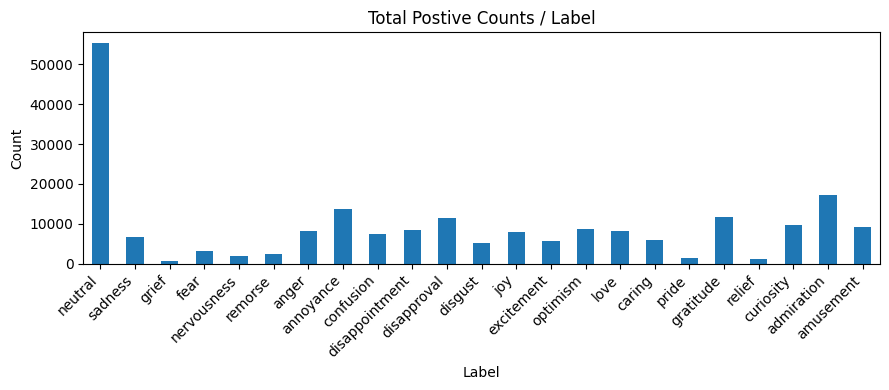

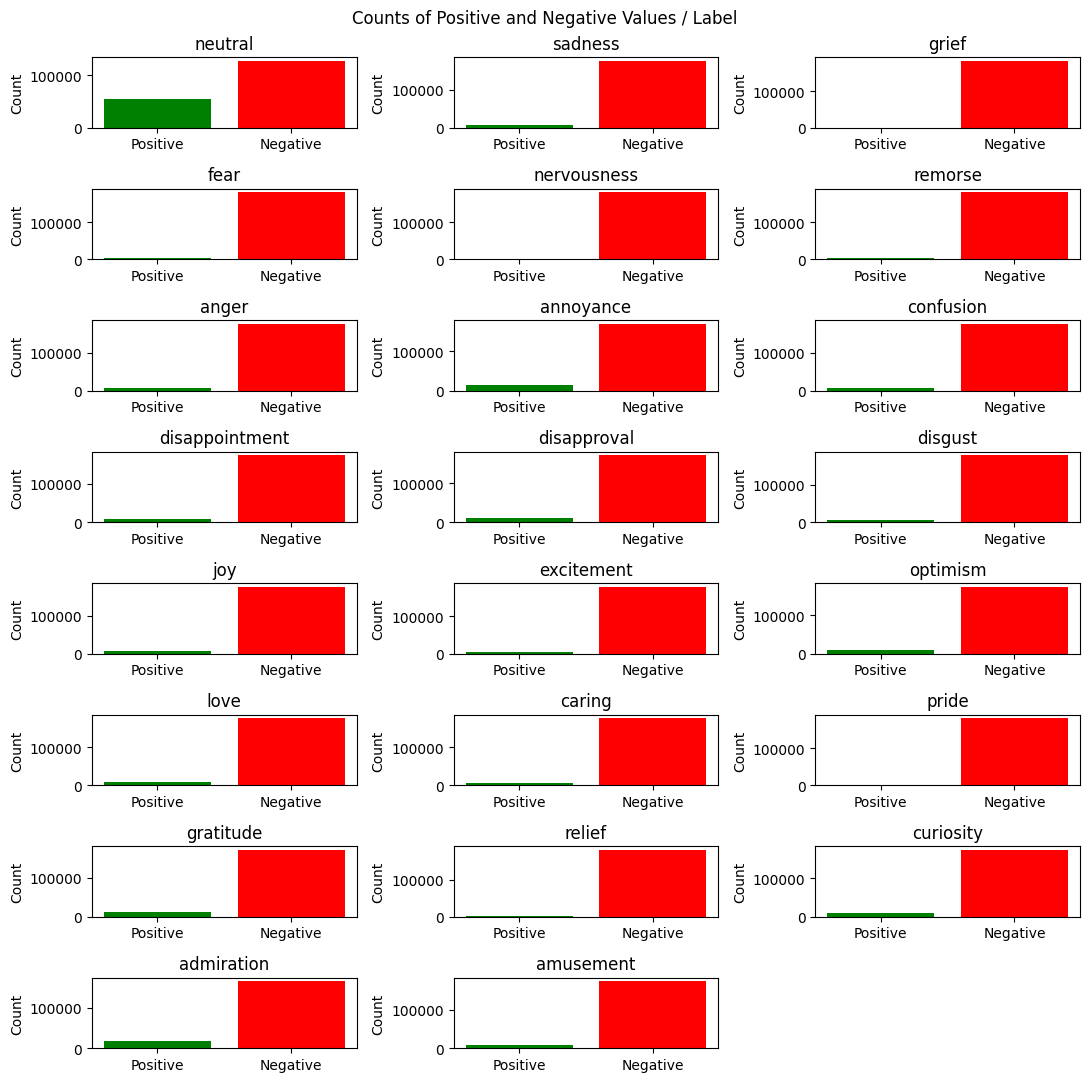

In [ ]:
# Calculate positive counts for each label
label_col_names = condensed_df.columns[1:]
positive_counts = (condensed_df[label_col_names] == 1).sum()

# Plot counts for each column
plt.figure(figsize=(9, 4))
positive_counts.plot(kind='bar')
plt.title('Total Postive Counts / Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()
print()

# Calculate negative count for each label
negative_counts = (condensed_df[label_col_names] == 0).sum()

# Create larger plot with subplots
num_labels = len(label_col_names)
fig, axes = plt.subplots(nrows=int(np.ceil(num_labels / 3)), ncols=3, figsize=(11, 11))
axes = axes.flatten()

# Plot each label's positive and negative counts in separate subplots
for i, label_name in enumerate(label_col_names):
    axes[i].bar(['Positive', 'Negative'], [positive_counts[label_name], negative_counts[label_name]], color=['green', 'red'])
    axes[i].set_title(label_name)
    axes[i].set_ylabel('Count')

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Counts of Positive and Negative Values / Label')
plt.tight_layout()
plt.show()

### Data Preprocessing ⭐

##### Text Cleaning (Baseline)

In [ ]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Expand contractions (e.g., "can't" -> "cannot")
    text = fix(text)

    # -------------------------------------------------------------------
    # (Comment out or remove for baseline - reintroduce later to test impact)
    # Replace emoticons with descriptive tokens
    # emoticons = {
    #     r':\)': '[SMILEYFACE]',
    #     r';\)': '[WINKYFACE]',
    #     r':d': '[SMILEYFACE]',
    #     r';d': '[WINKYFACE]',
    #     r':\(': '[FROWNYFACE]',
    #     r':o': '[SURPRISEDFACE]'
    # }
    # for pattern, replacement in emoticons.items():
    #     text = re.sub(pattern, replacement, text)

    # Replace exclamation marks and question marks with placeholders
    # text = re.sub(r'!', ' [EXCLAMATIONMARK]', text)
    # text = re.sub(r'\?', ' [QUESTIONMARK]', text)
    # -------------------------------------------------------------------

    # 3) Replace URLs with [URL]
    text = re.sub(r'(https?://\S+|www\.\S+)', '[URL]', text)

    # 4) Replace @handles with [USER]
    text = re.sub(r'@\w+', '[USER]', text)

    # -------------------------------------------------------------------
    # (Comment out or remove for baseline - reintroduce later to test impact)
    # Convert variations of [name] to [NAME]
    # text = re.sub(r'\[name\]', '[NAME]', text, flags=re.IGNORECASE')

    # Replace ellipses (two or more dots) with [ELLIPSIS]
    # text = re.sub(r'\.{2,}', ' [ELLIPSIS]', text)

    # Remove excessive repeated characters (e.g., "mmeEEEE" -> "me")
    # text = re.sub(r'([a-z])\1{2,}', r'\1', text)

    # Remove all non-alphabetical characters except spaces and square brackets
    # text = re.sub(r'[^a-zA-Z\s\[\]]', '', text)
    # -------------------------------------------------------------------

    # 5) Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

condensed_df['cleaned_text'] = condensed_df['text'].apply(clean_text)

In [ ]:
avg_length_before = condensed_df['text'].str.len().mean()
avg_length_after = condensed_df['cleaned_text'].str.len().mean()

print(f"Average length before cleaning: {avg_length_before:.2f} chars")
print(f"Average length after cleaning: {avg_length_after:.2f} chars\n")

# Print few reviews before and after cleaning
num_rows = len(condensed_df.index)
indexes = random.sample(range(0, num_rows), 5)

for i in indexes:
    review_dirty, review_clean = condensed_df['text'].loc[i], condensed_df['cleaned_text'].loc[i]
    print(f"Dirty Review: {review_dirty}\nClean Review: {review_clean}\n")

Average length before cleaning: 69.13 chars
Average length after cleaning: 69.88 chars

Dirty Review: I’ll do that. Thank you
Clean Review: i will do that. thank you

Dirty Review: Go to your room.
Clean Review: go to your room.

Dirty Review: Cold approach is a huge waste of time due to the ratio of success-failure
Clean Review: cold approach is a huge waste of time due to the ratio of success-failure

Dirty Review: Please seek medical help
Clean Review: please seek medical help

Dirty Review: Me too, my sister and I thought we became idiots, we even googled shapes and their sides
Clean Review: me too, my sister and i thought we became idiots, we even googled shapes and their sides



##### Stop Word Removal & Lemmatization (Baseline)

In [ ]:
# # Initialize stop words and lemmatizer
# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

# # Removes stopwords and performs lemmatization
# # Stopwords: such as "the," "is," "at," and "which" | Lemmatization: reducing words to their base or dictionary form, known as the lemma (e.g.,  "running" and "ran" would both be reduced to "run")
# def remove_stopWords_lemmatize(text):
#     # Tokenize text into words
#     words = text.split()

#     # Remove stopwords and lemmatize
#     processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

#     # Join words back into single string
#     return ' '.join(processed_words)

# # Apply preprocessing to cleaned_reviewBody column
# avg_length_before = condensed_df['cleaned_text'].str.len().mean()
# condensed_df['cleaned_text'] = condensed_df['cleaned_text'].apply(remove_stopWords_lemmatize)

# # Print avg char length before and after cleaning + stop word removal & lemmatization
# avg_length_after = condensed_df['cleaned_text'].str.len().mean()

# print(f"Average length before cleaning: {avg_length_before:.2f} chars")
# print(f"Average length after cleaning: {avg_length_after:.2f} chars\n")

# # Print sample reviews before and after cleaning + stop word removal & lemmatization
# num_rows = len(condensed_df.index)
# indexes = random.sample(range(0, num_rows), 3)

# for i in indexes:
#     review_dirty, review_clean = condensed_df['text'].loc[i], condensed_df['cleaned_text'].loc[i]
#     print(f"Dirty Review: {review_dirty}\nClean Review: {review_clean}\n")

##### Vocabulary Size & Words Per Sample Stats

In [ ]:
# Flatten all text into one string and split into words
all_text = " ".join(condensed_df['cleaned_text'])

# Create set of all unqiue words & count
vocabulary = set(all_text.split())
vocab_size = len(vocabulary)

print(f'Vocabulary size: {vocab_size}')

# Calculate number of words in each sample
word_counts = condensed_df['cleaned_text'].apply(lambda x: len(x.split()))

# Compute the average number of words per sample
avg_words = word_counts.mean()

print(f'Average number of words per sample: {avg_words:.2f}')

# Compute the highest and lowest word counts in the samples
max_words = word_counts.max()
min_words = word_counts.min()

print(f'Maximum words in a sample: {max_words}')
print(f'Minimum words in a sample: {min_words}')

Vocabulary size: 59060
Average number of words per sample: 13.49
Maximum words in a sample: 34
Minimum words in a sample: 1


##### Train-Test Split & Visualization

In [ ]:
# Initialize multi-label k-Fold splitter (https://github.com/trent-b/iterative-stratification/tree/master)
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Generate train-test splits and retrieve first split (change later when running kfold)
for train_idxs, test_idxs in mskf.split(condensed_df, condensed_df):
    train_df = condensed_df.iloc[train_idxs].reset_index(drop=True)
    test_df = condensed_df.iloc[test_idxs].reset_index(drop=True)
    break

dataset_size = condensed_df.shape[0]
train_size = train_df.shape[0]
test_size = test_df.shape[0]
print(f'Total number of examples in dataset: {dataset_size}\n'
      f'Total number of examples in train split: {train_size} ({(train_size / dataset_size) * 100:.2f}%)\n'
      f'Total number of examples in test split: {test_size} ({(test_size / dataset_size) * 100:.2f}%)')

Total number of examples in dataset: 183584
Total number of examples in train split: 146830 (79.98%)
Total number of examples in test split: 36754 (20.02%)


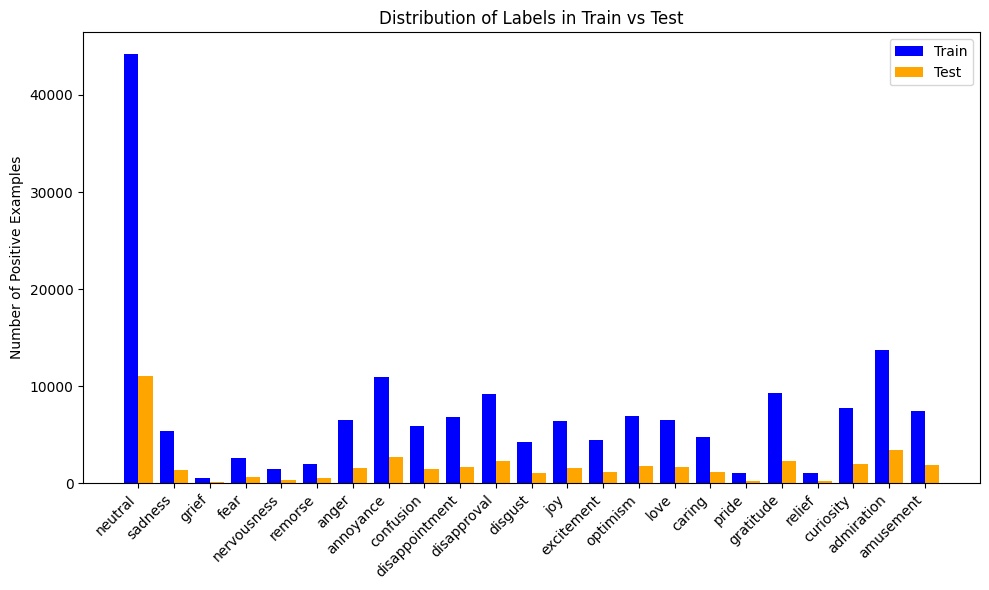

In [ ]:
# Extract target label col names (assumes all int64 columns are labels)
label_col_names = [col for col in train_df.columns if train_df[col].dtype == 'int64']

# Count positive instances / label in each split
train_counts = train_df[label_col_names].sum()
test_counts = test_df[label_col_names].sum()

x = np.arange(len(label_col_names))
bar_width = 0.4

# Side-by-side bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, train_counts, bar_width, label='Train', color='blue')
plt.bar(x + bar_width/2, test_counts, bar_width, label='Test', color='orange')

plt.xticks(x, label_col_names, rotation=45, ha='right')
plt.ylabel('Number of Positive Examples')
plt.title('Distribution of Labels in Train vs Test')
plt.legend()
plt.tight_layout()
plt.show()

### Modeling & Evaluation ⭐

#### Shared Functions

In [ ]:
def eval_clf_preds(y_true, y_preds, binary_clf_evals=False):
    multiLabel_metrics = {
        "Accuracy": accuracy_score(y_true, y_preds),
        "Precision": precision_score(y_true, y_preds, average='micro', zero_division=0),
        "Recall": recall_score(y_true, y_preds, average='micro', zero_division=0),
        "F1-Score": f1_score(y_true, y_preds, average='micro', zero_division=0)
    }

    eval_results = {"Multi-label": multiLabel_metrics}

    if binary_clf_evals:
        individual_evals = []
        num_labels = y_true.shape[1]
        for i in range(num_labels):
            acc = accuracy_score(y_true.iloc[:, i], y_preds.iloc[:, i])
            prec = precision_score(y_true.iloc[:, i], y_preds.iloc[:, i], zero_division=0)
            rec = recall_score(y_true.iloc[:, i], y_preds.iloc[:, i], zero_division=0)
            f1 = f1_score(y_true.iloc[:, i], y_preds.iloc[:, i], zero_division=0)
            individual_evals.append({
                "Target Label": f"{y_true.columns[i]}",
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1-Score": f1
            })
        eval_results["Binary"] = individual_evals

    return eval_results

#### Using Manually Extracted Features

##### Extract Features from Text using TF-ID

In [ ]:
# Initialize TF-ID feature vectorizer
vectorizer = TfidfVectorizer(max_features=100)

# Extract features from text instances in train and test splits
X_train = vectorizer.fit_transform(train_df['cleaned_text'])
X_test = vectorizer.transform(test_df['cleaned_text'])

# Define train and test multi-label targets
y_train = train_df.iloc[ : ,1:24]
y_test = test_df.iloc[ : ,1:24]

# (Number of documents, Number of featurs)
print(f"TF-IDF Features for Training Data: {X_train.shape}")
print(f"TF-IDF Features for Testing Data: {X_test.shape}")

TF-IDF Features for Training Data: (146830, 100)
TF-IDF Features for Testing Data: (36754, 100)


##### Logistic Regression & SVM Models for Multi-Label Targets (Binary Relevance)

###### Train One Logistic Regression Model & One SVM Model Per Label, Evaluate Performance

In [ ]:
# Train one classifier per emotion
lr_classifiers = []
for i in tqdm(range(y_train.shape[1]), desc="Training Logistic Regression Classifiers"):
    clf = LogisticRegression()
    clf.fit(X_train, y_train.iloc[:, i])
    lr_classifiers.append(clf)

# Train one SVM linear model per emotion
svm_classifiers = []
for i in tqdm(range(y_train.shape[1]), desc="Training SVM Classifiers"):
    clf = LinearSVC(max_iter=20)  # Specify linear kernel for SVM
    clf.fit(X_train, y_train.iloc[:, i])
    svm_classifiers.append(clf)

Training SVM Classifiers: 100%|██████████| 22/22 [00:10<00:00,  2.13it/s]


In [ ]:
# Store predictions of individual logistic regression classifiers on train and tests sets
csfs_y_preds_train = pd.DataFrame({i: clf.predict(X_train) for i, clf in enumerate(lr_classifiers)})
csfs_y_preds_test = pd.DataFrame({i: clf.predict(X_test) for i, clf in enumerate(lr_classifiers)})

# Evaluate performance on multi-label task
results_train_lr = evaluate_clf_models(y_train, csfs_y_preds_train, dataset_type="train", model_type="Logistic Regression")
results_test_lr = evaluate_clf_models(y_test, csfs_y_preds_test, dataset_type="test", model_type="Logistic Regression")

# Store predictions of individual svm classifiers on train and tests sets
csfs_y_preds_train = pd.DataFrame({i: clf.predict(X_train) for i, clf in enumerate(svm_classifiers)})
csfs_y_preds_test = pd.DataFrame({i: clf.predict(X_test) for i, clf in enumerate(svm_classifiers)})

# Evaluate performance on multi-label task
results_train_svm = evaluate_clf_models(y_train, csfs_y_preds_train, dataset_type="train", model_type="SVM")
results_test_svm = evaluate_clf_models(y_test, csfs_y_preds_test, dataset_type="test", model_type="SVM")

Overall Multi-label Classification Metrics for Logistic Regression on train dataset:
Accuracy: 0.0958
Precision: 0.7467
Recall: 0.0703
F1-Score: 0.1284
(Samples tested: 146830)
--------------------------------------------------
Overall Multi-label Classification Metrics for Logistic Regression on test dataset:
Accuracy: 0.0978
Precision: 0.7489
Recall: 0.0714
F1-Score: 0.1304
(Samples tested: 36754)
--------------------------------------------------
Overall Multi-label Classification Metrics for SVM on train dataset:
Accuracy: 0.0914
Precision: 0.7809
Recall: 0.0661
F1-Score: 0.1218
(Samples tested: 146830)
--------------------------------------------------
Overall Multi-label Classification Metrics for SVM on test dataset:
Accuracy: 0.0922
Precision: 0.7753
Recall: 0.0662
F1-Score: 0.1219
(Samples tested: 36754)
--------------------------------------------------


##### RakelO (Ensemble Method)

###### Train RakeIo Classifier, Evaluate Performance

In [ ]:
# Note: Model reuses TFID-feats extracted previously

# Docs: http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO
cfr = RakelO(
    base_classifier=LogisticRegression(max_iter=1000),
    model_count=(2 * y_train.shape[1])
)

# Train classifier on training data
cfr.fit(X_train, y_train)

# Store predictions of classifier
y_pred_train = cfr.predict(X_train)
y_pred_test = cfr.predict(X_test)

In [ ]:
# Evaluate performance
results_train_rakeio = evaluate_clf_model(y_train, y_pred_train, 'train', 'RakelO (LR Ensemble)')
results_test_rakeio = evaluate_clf_model(y_test, y_pred_test, 'test', 'RakelO (LR Ensemble)')

Overall Multi-label Classification Metrics for RakelO (LR Ensemble) on train dataset:
Accuracy: 0.1013
Precision: 0.7198
Recall: 0.0757
F1-Score: 0.1370
(Samples tested: 146830)
--------------------------------------------------
Overall Multi-label Classification Metrics for RakelO (LR Ensemble) on test dataset:
Accuracy: 0.1028
Precision: 0.7228
Recall: 0.0763
F1-Score: 0.1381
(Samples tested: 36754)
--------------------------------------------------


#### Using Learned Features

##### Extracting Feature Embeddings using DistilBERT & RoBERTa

###### Load Instances of Tokenizers and Model Classes with Pre-Trained Models

In [ ]:
def load_tokenizer_model_instances(class_pairs, model_names):
    """
    Loads tokenizer and model instances for each provided model name using the corresponding classes.
    Args:
        class_pairs (List[Tuple[TokenizerClass, ModelClass]]):
            A list of tuples where each tuple pairs a tokenizer class and model class from Hugging Face's Transformers library.
        model_names (List[str]):
            A list of pre-trained model names. Where model name i is associated to class pair i in class_pairs.
    Returns:
        List[Tuple[tokenizer, model]]:
            A list of tuples, where each tuple contains a tokenizer instance and a model instance loaded with the pre-trained model
            and set to evaluation mode.
    """
    loaded_tokenizer_model_pairs = []

    for i in range(len(model_names)):
        tokenizer_class, model_class = classPairs[i]
        tokenizer = tokenizer_class.from_pretrained(model_names[i])
        model = model_class.from_pretrained(model_names[i])
        model.eval()
        loaded_tokenizer_model_pairs.append((tokenizer, model))

    return loaded_tokenizer_model_pairs

# Define Transformers model and tokenizer classes and selected pre-trained model names
tokenizer_model_class_pairs = [(DistilBertTokenizer, DistilBertModel), (RobertaTokenizer, RobertaModel)]
embedding_model_names = ['distilbert-base-uncased', 'roberta-base']

# Load pre-trained tokenizers and models
loaded_tokenizer_model_class_pairs = load_tokenizer_model_instances(tokenizer_model_class_pairs, embedding_model_names)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###### Create Tokenizing Datasets (TokenizerDataset) and Setup DataLoaders for Inferencing Embedding Models

In [ ]:
class TokenizerDataset(Dataset):
    """
    A PyTorch Dataset that tokenizes text data and prepares model inputs along with corresponding labels.
    Args:
        df (pandas.DataFrame): DataFrame containing text and label data.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer instance with a `from_pretrained` method.
        text_column (str, optional): Name of the column in the DataFrame that contains text data. Defaults to 'cleaned_text'.
    """
    def __init__(self, df, tokenizer, text_column='cleaned_text'):
        self.df = df
        self.tokenizer = tokenizer
        self.text_col = text_column

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        """
        Retrieves tokenized data and labels for a given index.

        This method extracts the text from the specified column in the DataFrame, tokenizes it with padding and truncation, and
        converts the tokenized outputs to flattened tensors. It also extracts label data from a slice of the row, converts it
        to a float tensor, and returns the index for reference.
        """
        row = self.df.iloc[idx]
        text = str(row[self.text_col])

        # Tokenizers inherit from base class: https://huggingface.co/docs/transformers/v4.48.2/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.__call__
        encoding = self.tokenizer(
            text,
            max_length=128, # Max number of words to tokenize per text entry
            padding='max_length', # Pad (with 0s) tokenized sequences of length < max_length
            truncation=True, # Drop all tokenized words after max_length (if applicable)
            return_tensors='pt' # Return tensors of type torch.Tensor instead of python integers
        )

        # Note: see 'Returns' section in tokenizer base class (linked above) for additional descriptions of data returned and accessed through 'encoding'
        # 'flatten()' is used to ensure the output is a 1D sequence of integers; originally they are of shape (1, sequence_length) rather than just (sequence_length); 1 represents the a batch of one sample
        item = {
            'input_ids': encoding['input_ids'].flatten(), # List of integers, where each integer corresponds to a token produced by the tokenizer
            'attention_mask': encoding['attention_mask'].flatten(), # List of integers that tells the model which tokens in the input_ids should be actively considered during processing (0 or 1)
        }

        if 'token_type_ids' in encoding:
            item['token_type_ids'] = encoding['token_type_ids'].flatten() # List of integers used to indicate the segment of a sentence each token in the input_ids belongs to

        labels_series = row[1:24].astype(np.int64)
        item['labels'] = torch.tensor(labels_series.to_numpy(), dtype=torch.float32)
        item['index'] = idx

        return item

def create_tokenizer_dataLoaders(tokenizer_model_pairs, device):
    """
    Creates pairs train and test TokenizerDataset DataLoaders used for batch inferencing embedding models.

    **Note:** This function expects that `train_df` and `test_df` are defined as pandas DataFrames
    accessible in the global scope.

    Args:
        tokenizer_model_pairs (List[Tuple[tokenizer, model]]):
            Pairs of tokenizer instances and model instances loaded with a pre-trained model
        device (torch.device):
            The device on which the model should be placed.

    Returns:
        List[Tuple[DataLoader, DataLoader]]:
            A list of tuples, where each tuple contains a DataLoader for the training dataset a DataLoader for the testing dataset, set
            to load tokenized text data.
    """
    tokenizer_dataLoaders = []

    for tokenizer, model in tokenizer_model_pairs:
        model.to(device)
        train_dataset = TokenizerDataset(train_df, tokenizer)
        test_dataset  = TokenizerDataset(test_df, tokenizer)

        # https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
        train_dataLoader = DataLoader(train_dataset, batch_size=16) # Shuffle data at every epoch while training
        test_dataLoader  = DataLoader(test_dataset, batch_size=16)

        tokenizer_dataLoaders.append((train_dataLoader, test_dataLoader))

    return tokenizer_dataLoaders

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Setup train and dataLoader pairs for each model
tokenizer_DataLoader_pairs = create_tokenizer_dataLoaders(loaded_tokenizer_model_class_pairs, device)

###### Inference Embedding Models & Create Embedding Datasets (FeatureEmbeddingDataset)

In [ ]:
class FeatureEmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return self.embeddings.shape[0]

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx], idx

In [ ]:
def extract_feature_embeddings(dataloader, model, device, model_name, data_split_name):
    """
    Extracts feature embeddings and labels from a DataLoader using a given model. The extracted embeddings and labels from
    each batch are concatenated and wrapped into a FeatureEmbeddingDataset.

    Args:
        dataloader (torch.utils.data.DataLoader):
            DataLoader providing batches of tokenized inputs and labels.
        model (torch.nn.Module):
            The loaded model to use to compute the embeddings. The model should output either a
            `pooler_output` or a `last_hidden_state` attribute.
        device (torch.device):
            The device (CPU or GPU) on which the model inference should run.
        model_name (str):
            A string identifier for the model. Used for descriptive progress output.
        data_split_name (str):
            A string indicating the data split (e.g., 'train', 'test') for progress display.

    Returns:
        FeatureEmbeddingDataset:
            A dataset containing the concatenated feature embeddings and corresponding labels.
    """
    embedding_batches = []
    label_batches = []

    # inference_mode() helps model get better performance by disabling training layers in model; https://pytorch.org/docs/stable/generated/torch.autograd.grad_mode.inference_mode.html
    with torch.inference_mode():
        for batch in tqdm(dataloader, desc=f"Extracting feature embeddings from {data_split_name} split using {model_name}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Check if model includes 'pooler_output' (designed to summarize the entire input sequence)
            if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
                embeddings = outputs.pooler_output
            else:
                embeddings = outputs.last_hidden_state[:, 0, :] # 'outputs' is of shape (batch_size, sequence_length, hidden_size); here we select all samples in the batch, the first dimension (i.e., the [CLS] token that represents the overall sequence), all features for that token

            embedding_batches.append(embeddings.cpu())
            label_batches.append(batch['labels'])

        # Combines separate tensors created from each batch into a single tensor that represents the embeddings / labels for the entire dataset
        embeddings = torch.cat(embedding_batches, dim=0)
        labels = torch.cat(label_batches, dim=0)

        return FeatureEmbeddingDataset(embeddings, labels)

def create_feature_embedding_datasets(tokenizer_dataLoader_pairs, loaded_tokenizer_model_class_pairs, device):
    """
    Creates feature embedding datasets for both training and testing splits for each tokenizer/model pair.

    Args:
        tokenizer_dataLoader_pairs (List[Tuple[DataLoader, DataLoader]]):
            A list of tuples, each containing a training DataLoader and a testing DataLoader for loading tokenized data.
        loaded_tokenizer_model_class_pairs (List[Tuple[tokenizer, model]]):
            A list of tuples where each tuple consists of a tokenizer instance and a model instance. The model instance is used to extract feature
            embeddings.
        device (torch.device):
            The device on which model inference should run (e.g., CPU or GPU).

    Returns:
        List[Tuple[FeatureEmbeddingDataset, FeatureEmbeddingDataset]]:
            A list of tuples, where each tuple contains a FeatureEmbeddingDataset for the training split and a FeatureEmbeddingDataset for the
            testing split.
    """
    feature_embedding_dataset_pairs = []

    for i, pair in enumerate(tokenizer_dataLoader_pairs):
        train_dataset  = extract_feature_embeddings(pair[0], loaded_tokenizer_model_class_pairs[i][1], device, embedding_model_names[i], 'train')
        test_dataset = extract_feature_embeddings(pair[1], loaded_tokenizer_model_class_pairs[i][1], device, embedding_model_names[i], 'test')

        feature_embedding_dataset_pairs.append((train_dataset, test_dataset))

    return feature_embedding_dataset_pairs

# Create pairs of train and test PyTorch datasets which contain feature embedding representations of the input data (1 pair per embedding model)
feature_embedding_dataset_pairs = create_feature_embedding_datasets(tokenizer_DataLoader_pairs, loaded_tokenizer_model_class_pairs, device)

Extracting feature embeddings from train split using distilbert-base-uncased: 100%|██████████| 9177/9177 [10:20<00:00, 14.79it/s]
Extracting feature embeddings from test split using distilbert-base-uncased: 100%|██████████| 2298/2298 [02:28<00:00, 15.45it/s]
Extracting feature embeddings from train split using roberta-base: 100%|██████████| 9177/9177 [16:58<00:00,  9.01it/s]
Extracting feature embeddings from test split using roberta-base: 100%|██████████| 2298/2298 [04:05<00:00,  9.35it/s]


###### Save Embedding Datasets to Google Drive

In [ ]:
def prepare_folder(folder_path, clear_folder=True):
    if os.path.exists(folder_path):
        if clear_folder:
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)
    else:
        os.makedirs(folder_path)

def save_dataset_pairs(dataset_pairs, model_names, dataset_name):
    base_path = '/content/drive/MyDrive/multiLabelClassification'

    for i, (train_dataset, test_dataset) in enumerate(dataset_pairs):
        folder_path = os.path.join(base_path, model_names[i])
        prepare_folder(folder_path, clear_folder=True)

        torch.save(train_dataset, os.path.join(folder_path, f'train_{dataset_name}.pt'))
        torch.save(test_dataset, os.path.join(folder_path, f'test_{dataset_name}.pt'))

save_dataset_pairs(feature_embedding_dataset_pairs, embedding_model_names, dataset_name='feature_embeddings_dataset')

###### Load Embedding Datasets & Setup DataLoaders for Training + Evaluating Models

In [ ]:
def load_dataset_pairs(model_names, dataset_name):
    embedding_dataset_pairs = []

    for name in model_names:
        # Note: need to have 'FeatureEmbeddingDataset' defined to load datasets
        train_dataset = torch.load(f'/content/drive/MyDrive/multiLabelClassification/{name}/train_{dataset_name}.pt')
        test_dataset = torch.load(f'/content/drive/MyDrive/multiLabelClassification/{name}/test_{dataset_name}.pt')
        embedding_dataset_pairs.append((train_dataset, test_dataset))

    return embedding_dataset_pairs

def create_dataLoaders(model_names):
    embedding_dataset_pairs = load_dataset_pairs(model_names, dataset_name='feature_embeddings_dataset')

    embedding_dataLoader_pairs = []

    for train_dataset, test_dataset in embedding_dataset_pairs:
        train_dataLoader = DataLoader(train_dataset, batch_size=256, shuffle=True) # shuffle=True since we are using this dataLoader for training
        test_dataLoader = DataLoader(test_dataset, batch_size=256)

        embedding_dataLoader_pairs.append((train_dataLoader, test_dataLoader))

    return embedding_dataLoader_pairs

pretrained_model_names = ['distilbert-base-uncased', 'roberta-base']

# Loads pairs of DataLoaders where each pair contains a train and test dataLoader, which load batches of data with feature embeddings as input values
embedding_dataLoader_pairs = create_dataLoaders(pretrained_model_names)

<ipython-input-23-3b779d00896c>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load(f'/content/drive/MyDrive/multiLabelClassification/{name}/train_{d

##### Train "Simple" Classifiers using Embeddings

In [ ]:
def train_clfs(embedding_model_names, dataLoader_pairs, num_labels, clf_loss_fns):
    """
    Trains binary relevance classifiers using embeddings produced by each embedding model.

    Args:
        embedding_model_names (list):
            Names of the pre-trained embedding models used for creating embeddings.
        dataLoader_pairs (list):
            Pairs of dataLoaders (train_dataLoader, test_dataLoader) for each embedding model.
        num_labels (int):
            Number of target labels in multi-label classificaiton task.
        clf_loss_fns (list):
            List of loss functions to use for the SGDClassifier.

    Returns:
        trained_clfs:
            A nested dictionary where: trained_clfs[embedding_model_name][clf_loss_fn][label_index] = trained binary classifier.
            trained_clfs[embedding_model_name][clf_loss_fn] = set of binary classifiers to be used for multi-label task.
    """
    # Holds all trained classifiers
    trained_clfs = {}

    # Retrieve train dataLoader for each embedding model
    for i, embedding_model_name in enumerate(embedding_model_names):
        train_dataLoader, _ = dataLoader_pairs[i]
        trained_clfs[embedding_model_name] = {}

        # Train a classifier (using binary relevance) per loss function
        for clf_loss_fn in clf_loss_fns:
            trained_clfs[embedding_model_name][clf_loss_fn] = []
            # Train one binary classifier per label and add to set
            for i in tqdm(range(num_labels), desc=f"Using {embedding_model_name}'s embeddings to train binary classifiers using {clf_loss_fn} (loss function)"):
                clf = SGDClassifier(loss=clf_loss_fn)
                # Train the classifier with mini-batch updates via partial_fit
                for embeddings_batch, labels_batch, _ in train_dataLoader:
                    # Convert tensors to NumPy arrays to ensure compatibility with partial_fit
                    X_batch = embeddings_batch.numpy()
                    y_batch = labels_batch.numpy()[:, i]

                    # Initialize binary classifier classes if not already set (only need to set first time)
                    if not hasattr(clf, 'classes_'):
                        clf.partial_fit(X_batch, y_batch, classes=[0, 1])
                    else:
                        clf.partial_fit(X_batch, y_batch)
                trained_clfs[embedding_model_name][clf_loss_fn].append(clf) # Add trained binary classifier to set of classifiers for current embedding model and loss function

        print("-" * 50)

    return trained_clfs

embedding_model_names = ['distilbert-base-uncased', 'roberta-base']
SGDClassifier_loss_functions = ['log_loss', 'hinge', 'modified_huber', 'squared_hinge', 'perceptron']
num_labels = train_df.shape[1] - 2 # -2 to account for text columns

# Train every classifier type (using binary relevance) using all model ebeddings as training data
trained_clfs = train_clfs(embedding_model_names, embedding_dataLoader_pairs, num_labels, SGDClassifier_loss_functions)

Using distilbert-base-uncased's embeddings to train binary classifiers using log_loss (loss function): 100%|██████████| 23/23 [00:58<00:00,  2.56s/it]
Using distilbert-base-uncased's embeddings to train binary classifiers using hinge (loss function): 100%|██████████| 23/23 [01:06<00:00,  2.89s/it]
Using distilbert-base-uncased's embeddings to train binary classifiers using modified_huber (loss function): 100%|██████████| 23/23 [00:52<00:00,  2.27s/it]
Using distilbert-base-uncased's embeddings to train binary classifiers using squared_hinge (loss function): 100%|██████████| 23/23 [00:51<00:00,  2.24s/it]
Using distilbert-base-uncased's embeddings to train binary classifiers using perceptron (loss function): 100%|██████████| 23/23 [01:12<00:00,  3.14s/it]


--------------------------------------------------


Using roberta-base's embeddings to train binary classifiers using log_loss (loss function): 100%|██████████| 23/23 [01:18<00:00,  3.43s/it]
Using roberta-base's embeddings to train binary classifiers using hinge (loss function): 100%|██████████| 23/23 [01:10<00:00,  3.06s/it]
Using roberta-base's embeddings to train binary classifiers using modified_huber (loss function): 100%|██████████| 23/23 [00:59<00:00,  2.58s/it]
Using roberta-base's embeddings to train binary classifiers using squared_hinge (loss function): 100%|██████████| 23/23 [00:59<00:00,  2.57s/it]
Using roberta-base's embeddings to train binary classifiers using perceptron (loss function): 100%|██████████| 23/23 [00:51<00:00,  2.24s/it]

--------------------------------------------------


###### Evaluate "Simple" Classifiers

In [ ]:
def get_binary_clfs_preds(binary_clfs, dataLoader):
    """
    Obtains predictions from each binary classifiers over all batches of data.
    **Note:** Since the dataLoader may shuffle samples, the function uses the original indices to sort the predictions back to the
    original order of the dataset.

    Args:
        binary_clfs (List of 'SGDClassifier' objects):
            A list of binary classifier objects.
        dataLoader (PyTorch dataLoader of dataset type FeatureEmbeddingDataset):
            Yields batches of embedding data in the form: (embeddings_batch, labels_batch, original_indices_batch).

    Returns:
        binary_clfs_preds (dict):
            A dictionary where: binary_clfs_preds[i] = NumPy array containing the predictions for binary classifier i, sorted in the same order as the original dataset (think of it as a column of predictions for a label)
    """
    # Holds all predictions for each binary classifier
    binary_clfs_preds = {i: [] for i in range(len(binary_clfs))}
    # Used to track original indicies of samples (needed when loading data from train_dataLoader since it shuffles each full batch of data)
    original_indices = []

    # Iterate over all batches of data provided by dataLoader
    for embeddings_batch, labels_batch, original_indices_batch in dataLoader:
        # .numpy() converts PyTorch tensor to a NumPy array
        original_indices.append(original_indices_batch.numpy())
        X_batch = embeddings_batch.numpy()

        # Retrieve and save predictions made by each binary classifier
        for i, clf in enumerate(binary_clfs):
            preds = clf.predict(X_batch)
            binary_clfs_preds[i].append(preds)

    # Combine each batch of predictions into a single NumPy array and add save to 'binary_clfs_preds'
    for i in binary_clfs_preds:
        binary_clfs_preds[i] = np.concatenate(binary_clfs_preds[i])

    original_indices = np.concatenate(original_indices) # Combine each batch of indicies into single NumPy array
    sorted_idx = np.argsort(original_indices) # Produces mapping that reorders the shuffled indices back to their original order (e.g., concatenated indices were [3, 1, 2], then np.argsort would return [1, 2, 0] (index 1 (which is 1) should come first, then index 2 (which is 2), followed by index 0 (which is 3))

    # Reorder predictions to ensure that each prediction lines up with its corresponding sample from the original dataset
    for i in binary_clfs_preds:
        binary_clfs_preds[i] = binary_clfs_preds[i][sorted_idx]

    return binary_clfs_preds

def evaluate_clfs(trained_clfs, embedding_model_names, dataLoader_pairs, y_train, y_test):
    """
    Args:
        embedding_model_names (List of 'SGDClassifier' objects):
            A list of binary classifier objects.
        dataLoader_pairs (PyTorch dataLoader of dataset type FeatureEmbeddingDataset):
            Yields batches of embedding data in the form: (embeddings_batch, labels_batch, original_indices_batch).
    Returns:
    eval_results:
        A nested dictionary where:
        eval_results[embedding_model_name][loss] =  {
            "train": train_results,
            "test": test_results
        }

        train_results & test_results = {
            "Multi-label": {
                "Accuracy": [float],
                "Precision": [float],
                "Recall": [float],
                "F1-Score": [float]
            }
        }
    """
    # Holds all evaluation results
    eval_results = {}

    # Calculate total number clfs to be evaluated
    total_steps = len(embedding_model_names) * len(SGDClassifier_loss_functions)

    with tqdm(total=total_steps, desc="Evaluating classifiers") as pbar:
        # Retrieve train and test embedding dataLoaders for each embedding model
        for i, embedding_model_name in enumerate(embedding_model_names):
            train_dataLoader, test_dataLoader = dataLoader_pairs[i]

            eval_results[embedding_model_name] = {}

            # For each trained classifier, get its predictions on train and test sets
            for loss_fn in trained_clfs[embedding_model_name]:
                binary_clfs = trained_clfs[embedding_model_name][loss_fn] # Set of binary classifiers

                # Retrieve predictions of each binary classifier for both data splits
                binary_clf_preds_train_dict = get_binary_clfs_preds(binary_clfs, train_dataLoader)
                binary_clf_preds_test_dict  = get_binary_clfs_preds(binary_clfs, test_dataLoader)

                # Convert dicitonary (containing predictions (value) of each binary classifier i (key)) to pandas df for evaluation
                binary_clf_preds_train_df = pd.DataFrame(binary_clf_preds_train_dict)
                binary_clf_preds_test_df  = pd.DataFrame(binary_clf_preds_test_dict)

                # Evaluate binary relevance classifiers' predictions
                train_results = eval_clf_preds(
                    y_train,
                    binary_clf_preds_train_df,
                )
                test_results = eval_clf_preds(
                    y_test,
                    binary_clf_preds_test_df,
                )

                # Save evaluations for clf model on multi-label task
                eval_results[embedding_model_name][loss_fn] = {
                    "train": train_results,
                    "test": test_results
                }

                pbar.update(1)

    return eval_results

# Collect ground truth values from original dataframes
y_train = train_df.iloc[ : ,1:24]
y_test = test_df.iloc[ : ,1:24]

# Retrieve evaluations of each binary relevance classifier on train and tests data splits
eval_results = evaluate_clfs(trained_clfs, embedding_model_names, embedding_dataLoader_pairs, y_train, y_test)

Evaluating classifiers: 100%|██████████| 10/10 [03:24<00:00, 20.44s/it]


###### Visualize Results

Evaluation Results:
+-------------------------+---------------------+--------------+------------+-------------+-----------+------------+
| Embedding Model         | Clf Loss Function   | Data Split   |   Accuracy |   Precision |    Recall |   F1-Score |
|-------------------------+---------------------+--------------+------------+-------------+-----------+------------|
| distilbert-base-uncased | log_loss            | train        | 0.103991   |   0.43098   | 0.26975   |  0.331816  |
| distilbert-base-uncased | log_loss            | test         | 0.101567   |   0.427043  | 0.266539  |  0.328219  |
| distilbert-base-uncased | hinge               | train        | 0.164701   |   0.211447  | 0.437283  |  0.285056  |
| distilbert-base-uncased | hinge               | test         | 0.162921   |   0.20718   | 0.430581  |  0.279753  |
| distilbert-base-uncased | modified_huber      | train        | 0.103228   |   0.139235  | 0.44184   |  0.211744  |
| distilbert-base-uncased | modified_huber  

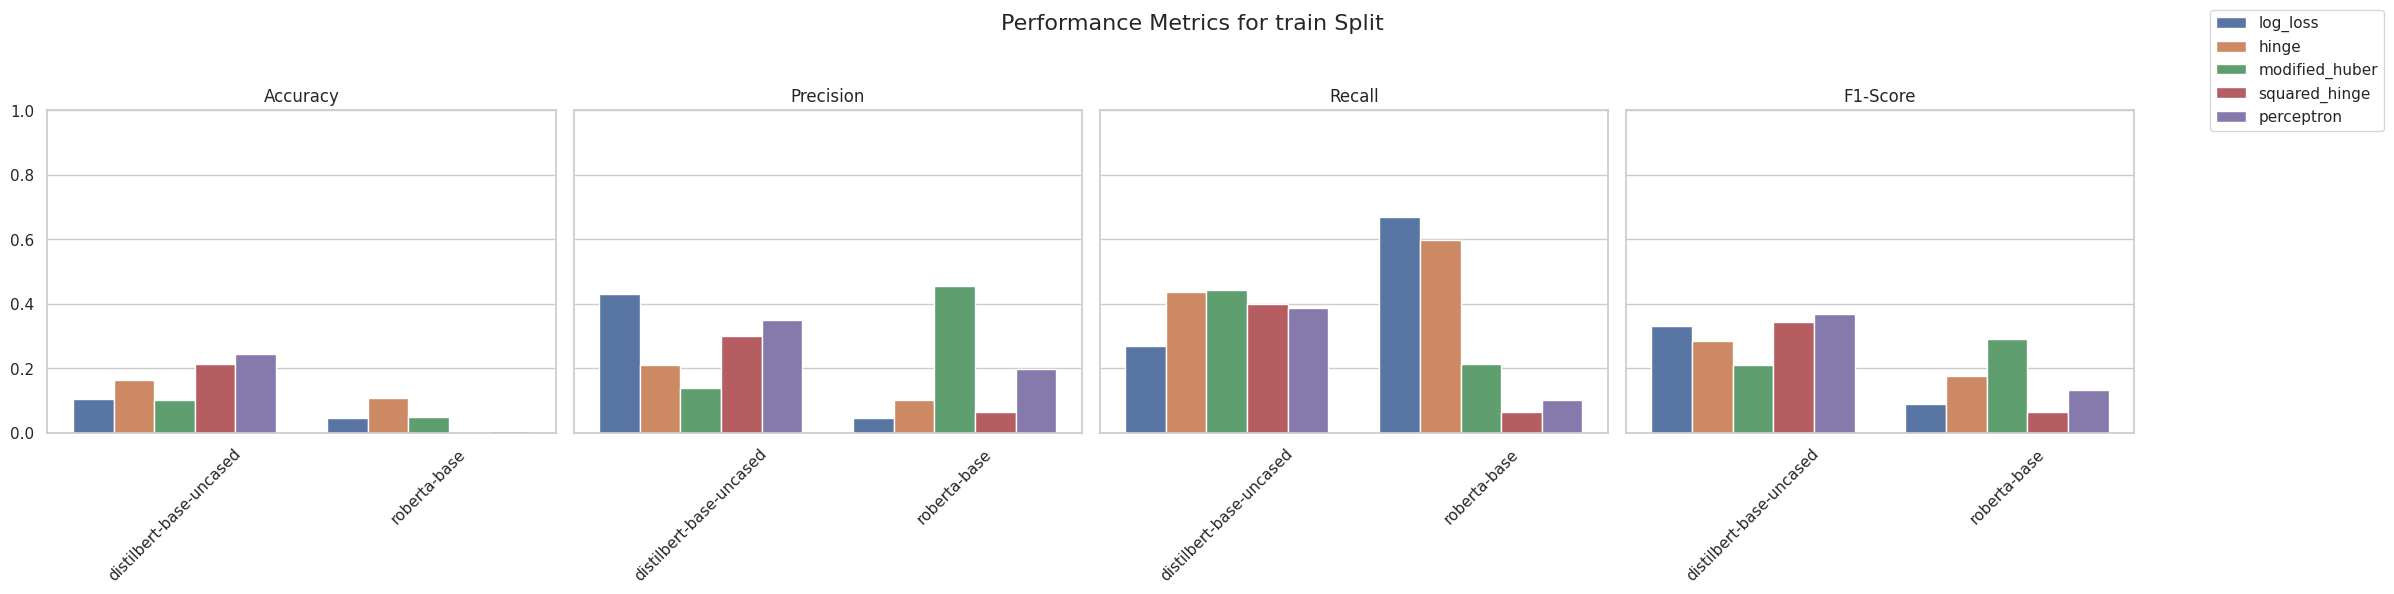

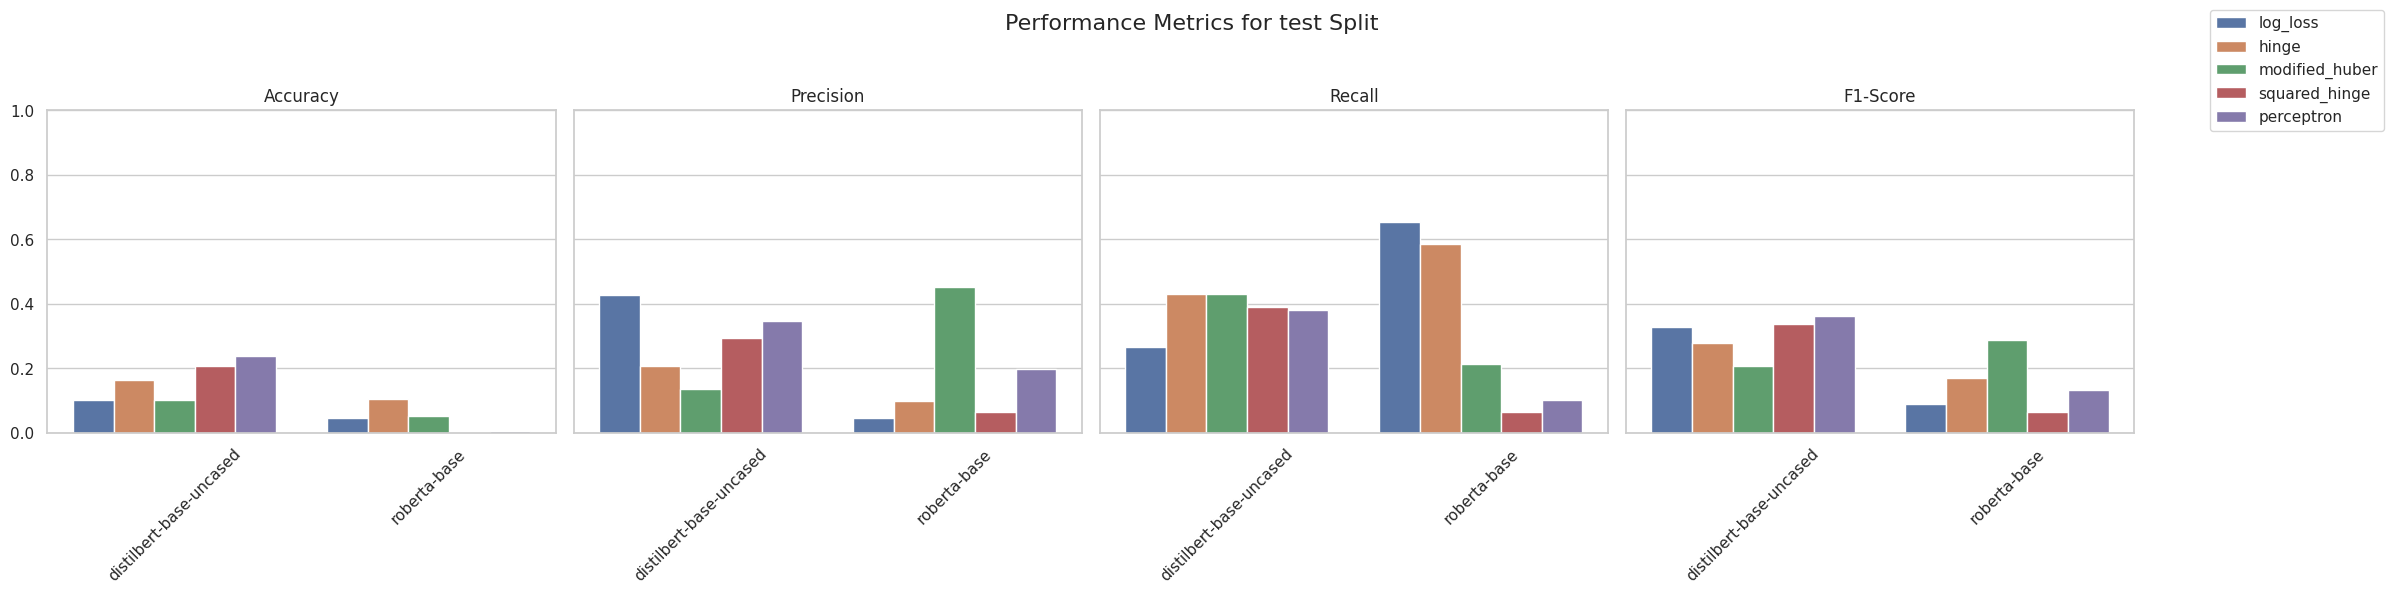

In [ ]:
def display_eval_results(eval_results):
    rows = []
    for embedding_model, loss_fns in eval_results.items():
        for loss_fn, splits in loss_fns.items():
            for split, metrics in splits.items():
                multi_label_metrics = metrics.get("Multi-label", {})
                rows.append([
                    embedding_model,
                    loss_fn,
                    split,
                    multi_label_metrics.get("Accuracy", None),
                    multi_label_metrics.get("Recall", None),
                    multi_label_metrics.get("Precision", None),
                    multi_label_metrics.get("F1-Score", None)
                ])

    columns = ["Embedding Model", "Clf Loss Function", "Data Split", "Accuracy", "Precision", "Recall", "F1-Score"]
    results_df = pd.DataFrame(rows, columns=columns)

    print("Evaluation Results:")
    print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False))

    sns.set(style="whitegrid")
    metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1-Score"]
    splits = results_df["Data Split"].unique()

    for split in splits:
        split_df = results_df[results_df["Data Split"] == split]
        num_metrics = len(metrics_to_plot)
        fig, axes = plt.subplots(1, num_metrics, figsize=(6 * num_metrics, 6), sharey=True)

        fig.suptitle(f"Performance Metrics for {split} Split", fontsize=16)

        if num_metrics == 1:
            axes = [axes]

        for i, (ax, metric) in enumerate(zip(axes, metrics_to_plot)):
            current_ax = sns.barplot(
                data=split_df,
                x="Embedding Model",
                y=metric,
                hue="Clf Loss Function",
                ax=ax,
                dodge=True
            )
            ax.set_title(f"{metric}")
            ax.set_ylim(0, 1)
            ax.set_ylabel("")
            ax.set_xlabel("")
            ax.tick_params(axis='x', rotation=45)

            if i >= 0:
                if ax.get_legend() is not None:
                    ax.get_legend().remove()

        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))

        fig.tight_layout(rect=[0, 0, 0.9, 0.95])
        plt.show()

display_eval_results(eval_results)

##### Train MLP using Embeddings (ToDo)

##### Fine-Tuning RoBERTa Model (ToDo)